In [1]:
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader,PyPDFLoader
from langchain_community.vectorstores import FAISS
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.prompts import PromptTemplate

In [2]:
from typing import TypedDict,Annotated
from langchain_core.documents import Document
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

class AgenticRAG(TypedDict):
    query:str
    documents_path:str
    documents:list[Document]
    chunks:list[Document]
    vectorstore:object
    retrieved_docs:list[Document]
    answer:str
    vectorstore_path:str
    messages: Annotated[list[BaseMessage], add_messages]

In [11]:
from langchain_core.prompts import PromptTemplate
prompt_template = PromptTemplate(template = """
You are a helpful assistant.
Here is past conversation:
{history}

Here are the relevant documents:
{context}

Now answer the user's question:
{question}
""",
input_variables=["context", "question","history"]
)



In [4]:
model = ChatGroq(model="Llama-3.3-70B-Versatile")

In [12]:
from tqdm import tqdm

EMBEDDER = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

def Document_Loader(state: AgenticRAG):
    path = os.path.abspath(state["documents_path"])  # ensure absolute
    if os.path.isfile(path):  # single PDF case
        loader = PyPDFLoader(path)
        loaded_pdf = loader.load()
    elif os.path.isdir(path):  # directory case
        loader = DirectoryLoader(
            path=path,
            glob="*.pdf",
            loader_cls=PyPDFLoader)
        loaded_pdf = loader.load()
    else:
        raise ValueError(f"Invalid documents_path: {path}")
    return {"documents": loaded_pdf}



def Text_Splitter(state:AgenticRAG):
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=199)
    chunks = splitter.split_documents(state["documents"])
    return {"chunks":chunks}

def Create_Vector_Store(state:AgenticRAG):
    embedder = EMBEDDER
    vector_store = FAISS.from_documents(documents=state["chunks"],embedding=embedder)
    vector_store.save_local(state["vectorstore_path"])

    return {"vectorstore_path":state["vectorstore_path"]}


def Load_Vector_Store(state:AgenticRAG):
    embedder = EMBEDDER
    vector_store = FAISS.load_local(folder_path=state["vectorstore_path"],
                                    embeddings=embedder,
                                    allow_dangerous_deserialization=True)
    return {"vectorstore_path":state["vectorstore_path"]}


def Retriever(state: AgenticRAG):
    vector_store = FAISS.load_local(
        folder_path=state["vectorstore_path"],
        embeddings=EMBEDDER,
        allow_dangerous_deserialization=True)
    retriever = vector_store.as_retriever()
    
    query = state["query"]

    docs = retriever.invoke(query)
    return {"retrieved_docs": docs}


# Converation Summery Memory

In [ ]:
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain.memory import ConversationSummaryMemory
from langchain_openai import ChatOpenAI   # or any LLM you are using


# Define your LLM for summarization (can be small/cheap model)
summary_llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

# Create conversation summary memory
chat_history = InMemoryChatMessageHistory()

memory = ConversationSummaryMemory(
    memory_key="chat_history",
    chat_memory=chat_history,
    llm=summary_llm,
    return_messages=True)


def rebuild_memory_from_state(state):
    """This function Rebuilds ConversationSummaryMemory by replaying saved Human/AI messages from persisted state, making the memory continuous across restarts.
    Run this before Agent function
    AFTER SERVER IS RESTART EMORY WILL STILL BE THIER
    """
    memory.chat_memory.clear()  # clear any old messages
    for msg in state.get("messages", []):
        if isinstance(msg, HumanMessage):
            memory.chat_memory.add_user_message(msg.content)
        elif isinstance(msg, AIMessage):
            memory.chat_memory.add_ai_message(msg.content)


def Agent(state: AgenticRAG):
     # Always rebuild memory from state before use
    rebuild_memory_from_state(state)
    
    docs = state["retrieved_docs"]
    context = "\n\n".join([doc.page_content for doc in docs])

    # Load summarized history
    past_dialogue = memory.load_memory_variables({})["chat_history"]

    # Format prompt
    formated_prompt = prompt_template.format(
        history=past_dialogue,
        context=context,
        question=state["query"]
    )

    response = model.invoke(formated_prompt)

    # Update summary memory properly
    memory.save_context(
        {"input": state["query"]}, 
        {"output": response.content})


    # Save to state instead of external memory
    state.setdefault("messages", [])
    state["messages"].append(HumanMessage(content=state["query"]))
    state["messages"].append(AIMessage(content=response.content))
    
    return {
        "answer": response.content,
        "messages": state["messages"]
    }


In [ ]:

def check_pdf_or_not(state: AgenticRAG):
    if state.get("documents_path") and not os.path.exists(state["vectorstore_path"]):
        return "create"
    else:
        return "load"

## StateGraph

In [15]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

db_path = os.path.abspath("./chat_hist/chat.db")
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = sqlite3.connect(database=db_path, check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

graph = StateGraph(AgenticRAG)

graph.add_node("Document_Loader",Document_Loader,)
graph.add_node("Text_Splitter",Text_Splitter)
graph.add_node("Create_Vector_Store",Create_Vector_Store)
graph.add_node("Load_Vector_Store",Load_Vector_Store)  
graph.add_node("Retriever",Retriever)
graph.add_node("Agent",Agent)

graph.add_conditional_edges(START,check_pdf_or_not,{"create":"Document_Loader",
                                                    "load":"Load_Vector_Store"})

# If new Vectorstore
graph.add_edge("Document_Loader","Text_Splitter")
graph.add_edge("Text_Splitter","Create_Vector_Store")
graph.add_edge("Create_Vector_Store","Retriever")

# if Loading VectorStore
graph.add_edge("Load_Vector_Store","Retriever")

graph.add_edge("Retriever", "Agent")
graph.add_edge("Agent", END)

app = graph.compile(checkpointer=checkpointer)

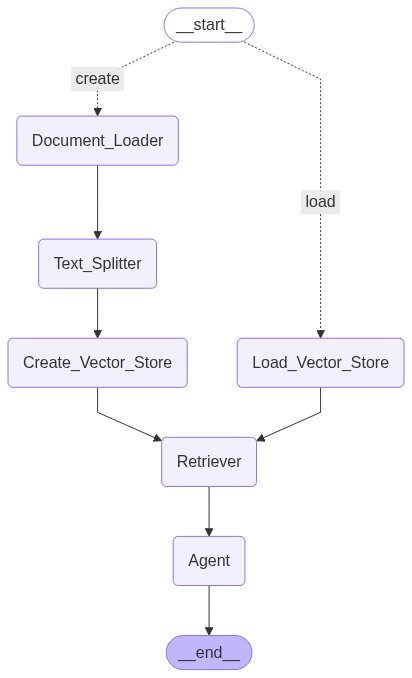

In [8]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png(max_retries=4)))

In [ ]:
CONFIG = {"configurable":{"thread_id":"1"}}
while True:
    query = input("Enter your query (or type 'exit' to quit): ")

    if query.lower() in ["exit", "bye", "close","stop"]:
        print("Exiting...")
        break

    user_input = {
        "vectorstore_path": "../vectorstores/legal_faiss",  
        "query": query}

    result = app.invoke(user_input,config=CONFIG)
    print("Query:", user_input["query"])
    print("Answer:", result["answer"])

Query: power of president
Answer: The provided documents appear to be related to the Constitution of Pakistan, specifically amendments made to it. However, they do not directly address the "power of the President" in a comprehensive manner. 

In the context of Pakistan, the President's powers are outlined in the Constitution of Pakistan, 1973. The President serves as the ceremonial head of state and has certain constitutional powers, including:

1. **Appointment of Prime Minister**: The President appoints the Prime Minister, who is the leader of the majority party or coalition in the National Assembly.
2. **Dissolution of National Assembly**: The President has the power to dissolve the National Assembly on the advice of the Prime Minister.
3. **Granting of Assent**: The President gives assent to parliamentary bills, which then become laws.
4. **Appointment of Governors**: The President appoints governors of the provinces on the advice of the Prime Minister.
5. **Appointment of Judges**